In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, classification_report
import random
from tqdm import tqdm, tqdm_notebook
from scipy import stats
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [0]:
df = pd.read_csv('ftable.csv')
df = df.iloc[:,3:]
df.head()
df.describe()

,los,gender,age,age65,major_s,minor_s,fever,anti_use,cepha_use,clinda_use,penic_use,quino_use,ppi_use,steroid_use,crrt_p,venti,gi_tube,ibd_p,elixhauser_vanwalraven,cdiff_p
count,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000,50016.000000
mean,4.543126,0.438180,62.195868,0.469370,0.175844,0.200496,0.103807,0.335693,0.160109,0.023433,0.040987,0.216791,0.490343,0.179203,0.017714,0.465611,0.451076,0.013456,5.728827,0.012076
std,6.966122,0.496169,16.674586,0.499066,0.380691,0.400375,0.305013,0.472237,0.366711,0.151274,0.198262,0.412063,0.499912,0.383526,0.131912,0.498821,0.497606,0.115217,7.120388,0.109227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.000000,0.000000
25%,1.000000,0.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,63.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
75%,5.000000,1.000000,75.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,10.000000,0.000000
max,169.000000,1.000000,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.000000,1.000000


All features was obtained from structured data in MIMICIII except major_s and minor_s. Symptoms were extracted from progress notes using NimbleMinner (word embedding models and positive only labels learning). major_s is defined as having diarrhea while minor_s abdominal cramping pain, nausea, or anorexia. If any of those ever occured in the notes, the major_s or minor_s is recorded as positive (binomial). 

In [0]:
#Drop ICU stay shorter then 24 hrs.
df = df.drop(df.index[df.los==0])
df[df.los==0]
df.to_csv('refined.csv')

cdiff_p
0    43995
1      604
dtype: int64


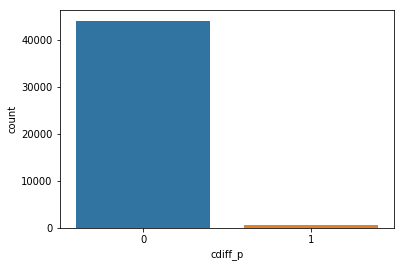

In [0]:
import seaborn as sns
print(df.groupby('cdiff_p').size())
sns.countplot(x="cdiff_p", data=df)
# 604 out of 43995 were diagnosed of cdi

In [0]:
# df without symptoms
df_nos = df.drop(['major_s','minor_s'], axis=1)
#df_nos = df[['major_s','minor_s','cdiff_p']]
df_nos.head()

,los,gender,age,age65,fever,anti_use,cepha_use,clinda_use,penic_use,quino_use,ppi_use,steroid_use,crrt_p,venti,gi_tube,ibd_p,elixhauser_vanwalraven,cdiff_p
0,2.0,1,54.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,5,0
1,11.0,0,21.0,0,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0,1,1.0,0.0,-7,0
2,4.0,0,55.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1.0,0.0,18,0
3,1.0,0,27.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,2,0
4,1.0,0,58.0,0,0,1,1.0,0.0,0.0,1.0,1.0,0.0,0,0,0.0,0.0,25,0


In [0]:
X = df.iloc[:,:-1]
X = X.to_numpy()
y = df.iloc[:,-1]
y = y.to_numpy()
X.shape

(44599, 19)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 50)
print(y_train.mean(), y_val.mean(),y_test.mean())
print(X_train.shape, X_val.shape,X_test.shape)
#50

0.01334118108691387 0.01390134529147982 0.014798206278026907
(35679, 19) (4460, 19) (4460, 19)


In [0]:
# df_nos
X = df_nos.iloc[:,:-1]
X_nos = X.to_numpy()
y = df_nos.iloc[:,-1]
y_nos = y.to_numpy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: cdiff_p, dtype: int64

In [0]:
X_nos_train, X_nos_test, y_nos_train, y_nos_test = train_test_split(X_nos, y_nos, test_size = 0.2, random_state = 50)
X_nos_test, X_nos_val, y_nos_test, y_nos_val = train_test_split(X_nos_test, y_nos_test, test_size = 0.5, random_state = 50)
print(y_nos_train.mean(), y_nos_val.mean(),y_nos_test.mean())
print(X_nos_train.shape, X_nos_val.shape,X_nos_test.shape)
#50

0.01334118108691387 0.01390134529147982 0.014798206278026907
(35679, 17) (4460, 17) (4460, 17)


In [0]:
#resampling methods
def BootstrapData(X, y, n):
    """
    Input X, y: data
            n: factor of bootstrapping
    Output X_bs, y_bs: bootstrapped data
    """
    
    bootStrapSampleIdxs = np.array(random.choices(range(X.shape[0]), k = n*X.shape[0]))
    X_bs = X[bootStrapSampleIdxs]
    y_bs = y[bootStrapSampleIdxs]
    return(X_bs, y_bs)

def DownSampling(X, y, n):
    """
    The function downsample the majority group by a factor n
    Input X, y: training data
            n: factor of fraction
    Output X_ds, y_ds: downsampled training set
    """
    p_idx = y == 0
    X_major = X[p_idx]
    y_major = y[p_idx]
    n_idx = y == 1
    X_minor = X[n_idx] 
    y_minor = y[n_idx] 
    # split data into major and minor group
    downsampledIdx = np.array(random.choices(range(X_major.shape[0]), k = round(X_major.shape[0]/n)))
    X_major_ds = X[downsampledIdx]
    y_major_ds = y[downsampledIdx]
    # downsample the major group
    X_ds = np.vstack((X_major_ds, X_minor))
    y_ds = np.hstack((y_major_ds, y_minor))
    # Concat the major and minor group
    return(X_ds, y_ds)
                                   
def UpSampling(X,y,n):
    """
    The function oversample the minor group with bootstrap by a factor n
    
    """
    p_idx = y_train == 0
    X_major = X_train[p_idx]
    y_major = y_train[p_idx]
    n_idx = y_train == 1
    X_minor = X_train[n_idx] 
    y_minor = y_train[n_idx] 
    # split data into major and minor group
    X_minor_bs, y_minor_bs = BootstrapData(X_minor, y_minor, n*X_major.shape[0])
    # bootstrap the minor group
    X_us = np.vstack((X_major, X_minor_bs))
    y_us = np.hstack((y_major, y_minor_bs))
    return(X_us, y_us)
                                   

In [0]:
class ensembleClassifier(BaseEstimator, ClassifierMixin):  

    def __init__(self, nEstimators, resampling, rs_factor, threshold):
        self.nEstimators = nEstimators
        self.resampling = resampling
        self.rs_factor = rs_factor
        self.threshold = threshold

    def fit(self, X, y):
        """
        Fits the classifier by fitting all ensemble models on bootstrapped data.
        Input:
        Input X, y: training data
        Output:
            self (ensembleClassifier)
        """
        # Fit nEstimators logistic regressions

        self.estimators_ = []
        for est in tqdm_notebook(range(self.nEstimators)):
            X_rs, y_rs = self.resampling(X, y, self.rs_factor)
            #print(X_rs.shape, y_rs.shape)
            self.model = LogisticRegressionCV(cv=5,penalty='l1', solver='saga',max_iter=2000).fit(X_rs, y_rs)
            self.estimators_.append(self.model)

        #print(self.estimators_)
        return(self)

    def predict(self, X):
        """
        Description: For each of your classification models make a class prediction for each 
            observation. Take an average of all predictions and use a threshold of 0.5 to make a class prediction
            to create an overall ensemble prediction.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
        Output:
            predictions (np.array): A numpy array of 1s or 0s indicating a prediction for all
                n inputs in X.
        """
        try:
            getattr(self, "estimators_")
        except AttributeError:
            raise RuntimeError("You're gonna want to train the your estimators first")
        
        # Make some predictions
        self.avg_yfit = np.zeros(X.shape[0])
        self.avg_yprob = np.zeros(X.shape[0])
        #print(X.shape)
   
        for model in self.estimators_: 
            #yfit = model.predict(X)
            #self.avg_yfit += yfit
            probs = model.predict_proba(X)
            self.avg_yprob += probs[:,1]
            #print(self.avg_yprob)
            #print(self.avg_yprob.shape)
        #self.avg_yfit = self.avg_yfit/self.nEstimators
        #b_yfit = self.avg_yfit >=0.5
        self.avg_yprob = self.avg_yprob/self.nEstimators
        b_yfit = self.avg_yprob >= self.threshold
        self.predictions = b_yfit.astype(int)
        # End your code
        return(self.predictions)

    def score(self, X, y):
        """
        Description: Using your prediction function predict the classes for X, and assess performance 
            against y using accuracy.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
            y (numpy array): A numpy array of classes with the same number of observations as X
        Output:
            accuracy (float): a float between 0 and 1 indicating how many elements you predicted the
                correct class for
        """
        #print(X.shape)
        y_pred = self.predict(X)
        self.classification = classification_report(y, y_pred)
        self.accuracy = accuracy_score(y, y_pred)
        print('Accuracy: ', self.accuracy)
        print('Classification report: \np', self.classification)
        #print('Confusion matrix: \np', confusion_matrix(y_val, y_pred))
        mat = confusion_matrix(y, y_pred)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        
        return 

/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy:  0.842152466367713
Classification report: 
p               precision    recall  f1-score   support

           0       0.99      0.84      0.91      4394
           1       0.06      0.70      0.12        66

   micro avg       0.84      0.84      0.84      4460
   macro avg       0.53      0.77      0.51      4460
weighted avg       0.98      0.84      0.90      4460



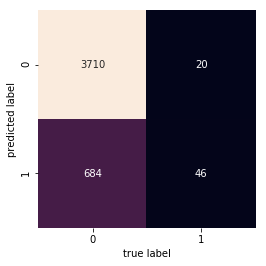

In [0]:
#Emsemble Logistic Regression
LLS = ensembleClassifier(nEstimators = 40, resampling=DownSampling, rs_factor = 40, threshold =0.5)
LLS.fit(X = X_train, y = y_train)
score = LLS.score(X_test, y_test)
score

/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reac

/Users/lhfu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy:  0.8587443946188341
Classification report: 
p               precision    recall  f1-score   support

           0       0.99      0.86      0.92      4394
           1       0.06      0.58      0.11        66

   micro avg       0.86      0.86      0.86      4460
   macro avg       0.53      0.72      0.52      4460
weighted avg       0.98      0.86      0.91      4460



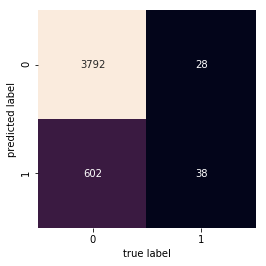

In [0]:
#Emsemble Logistic Regression without symptoms
LLS_nos = ensembleClassifier(nEstimators = 40, resampling=DownSampling, rs_factor = 40, threshold =0.5)
LLS_nos.fit(X = X_nos_train, y = y_nos_train)
score = LLS_nos.score(X_nos_test, y_nos_test)
score

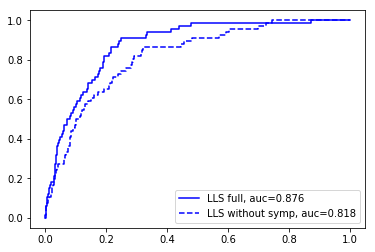

In [0]:
#AUC curve function
# calculate the fpr and tpr for all thresholds of the classification
#probs = model.predict_proba(X_test)
y_pred_proba = LLS.avg_yprob
y_nos_pred_proba = LLS_nos.avg_yprob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
fpr_nos, tpr_nos, _ = metrics.roc_curve(y_test,  y_nos_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_nos = metrics.roc_auc_score(y_test, y_nos_pred_proba)
plt.plot(fpr,tpr,c='b',label="LLS full, auc="+str(round(auc,3)))
plt.plot(fpr_nos,tpr_nos,c='b',linestyle='dashed',label="LLS without symp, auc="+str(round(auc_nos,3)))
plt.legend(loc=4)

In [0]:
from sklearn.ensemble import RandomForestClassifier
class ensembleClassifier(BaseEstimator, ClassifierMixin):  

    def __init__(self, nEstimators, resampling, rs_factor, threshold):
        self.nEstimators = nEstimators
        self.resampling = resampling
        self.rs_factor = rs_factor
        self.threshold = threshold

    def fit(self, X, y):
        """
        Fits the classifier by fitting all ensemble models on bootstrapped data.
        Input:
        Input X, y: training data
        Output:
            self (ensembleClassifier)
        """
        # Fit nEstimators logistic regressions
        # Your code here
        self.estimators_ = []
        for est in tqdm_notebook(range(self.nEstimators)):
            X_rs, y_rs = self.resampling(X, y, self.rs_factor)
            self.model = RandomForestClassifier(n_estimators=100, max_depth = 5).fit(X_rs, y_rs)
            self.estimators_.append(self.model)
        # End your code
        return(self)

    def predict(self, X):
        """
        Description: For each of your classification models make a class prediction for each 
            observation. Take an average of all predictions and use a threshold of 0.5 to make a class prediction
            to create an overall ensemble prediction.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
        Output:
            predictions (np.array): A numpy array of 1s or 0s indicating a prediction for all
                n inputs in X.
        """
        try:
            getattr(self, "estimators_")
        except AttributeError:
            raise RuntimeError("You're gonna want to train the your estimators first")
        
        # Make some predictions
        self.avg_yfit = np.zeros(X.shape[0])
        self.avg_yprob = np.zeros(X.shape[0])
        for model in self.estimators_: 
            #yfit = model.predict(X)
            #self.avg_yfit += yfit
            probs = model.predict_proba(X)
            self.avg_yprob += probs[:,1]
            #print(self.avg_yprob)
            #print(self.avg_yprob.shape)
        #self.avg_yfit = self.avg_yfit/self.nEstimators
        #b_yfit = self.avg_yfit >=0.5
        self.avg_yprob = self.avg_yprob/self.nEstimators
        b_yfit = self.avg_yprob >= self.threshold
        self.predictions = b_yfit.astype(int)
        # End your code
        return(self.predictions)

    def score(self, X, y):
        """
        Description: Using your prediction function predict the classes for X, and assess performance 
            against y using accuracy.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
            y (numpy array): A numpy array of classes with the same number of observations as X
        Output:
            accuracy (float): a float between 0 and 1 indicating how many elements you predicted the
                correct class for
        """
        y_pred = self.predict(X)
        self.classification = classification_report(y, y_pred)
        self.accuracy = accuracy_score(y, y_pred)
        print('Accuracy: ', self.accuracy)
        print('Classification report: \np', self.classification)
        #print('Confusion matrix: \np', confusion_matrix(y_val, y_pred))
        mat = confusion_matrix(y, y_pred)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        
        return 

Accuracy:  0.8403587443946189
Classification report: 
p               precision    recall  f1-score   support

           0       0.99      0.84      0.91      4394
           1       0.06      0.71      0.12        66

   micro avg       0.84      0.84      0.84      4460
   macro avg       0.53      0.78      0.51      4460
weighted avg       0.98      0.84      0.90      4460



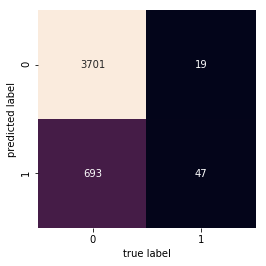

In [0]:
#Random forest classifier with symptoms
tree_rf = ensembleClassifier(nEstimators = 40, resampling=DownSampling, rs_factor = 40,threshold =0.5)
tree_rf.fit(X = X_train, y = y_train)
score = tree_rf.score(X_test, y_test)
score

Accuracy:  0.8517937219730942
Classification report: 
p               precision    recall  f1-score   support

           0       0.99      0.86      0.92      4394
           1       0.06      0.61      0.11        66

   micro avg       0.85      0.85      0.85      4460
   macro avg       0.53      0.73      0.51      4460
weighted avg       0.98      0.85      0.91      4460



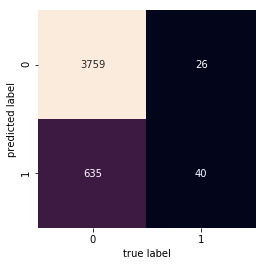

In [0]:
#Random forest classifier without symptoms
tree_rf_nos = ensembleClassifier(nEstimators = 40, resampling=DownSampling, rs_factor = 40,threshold =0.50)
tree_rf_nos.fit(X = X_nos_train, y = y_nos_train)
score = tree_rf_nos.score(X_nos_test, y_nos_test)
score

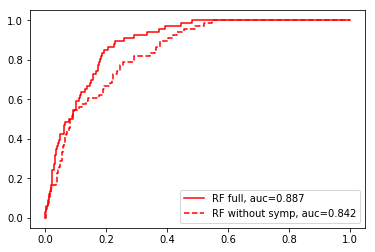

In [0]:
#AUC for rf
y_pred_proba = tree_rf.avg_yprob
y_nos_pred_proba = tree_rf_nos.avg_yprob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
fpr_nos, tpr_nos, _ = metrics.roc_curve(y_test,  y_nos_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_nos = metrics.roc_auc_score(y_test, y_nos_pred_proba)
plt.plot(fpr,tpr,c='r',label="RF full, auc="+str(round(auc,3)))
plt.plot(fpr_nos,tpr_nos,c='r',linestyle='dashed',label="RF without symp, auc="+str(round(auc_nos,3)))
plt.legend(loc=4)

In [0]:
# post hoc for linear
fp = X_test[(y_test != tree_rf.predictions) & (tree_rf.predictions == 1)]
tp = X_test[(y_test == tree_rf.predictions) & (tree_rf.predictions == 1)]
col = ['los','gender','age','age65','major_s','minor_s','fever','anti_use',
       'cepha_use','clinda_use','penic_use','quino_use','ppi_use','steroid_use','crrt_p','venti',
       'gi_tube','ibd_p','elixhauser_vanwalraven']
fp = pd.DataFrame(fp,columns=col)
tp = pd.DataFrame(tp,columns=col)
fp['cdiff_p']=0
tp['cdiff_p']=1
predict_a = pd.concat([fp,tp])
predict_a.describe()
predict_a.to_csv('predict_a.csv')

In [0]:
fp.elixhauser_vanwalraven.median()

11.0

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
class ensembleClassifier(BaseEstimator, ClassifierMixin):  

    def __init__(self, nEstimators, resampling, rs_factor, threshold):
        self.nEstimators = nEstimators
        self.resampling = resampling
        self.rs_factor = rs_factor
        self.threshold = threshold

    def fit(self, X, y):
        """
        Fits the classifier by fitting all ensemble models on bootstrapped data.
        Input:
        Input X, y: training data
        Output:
            self (ensembleClassifier)
        """
        # Fit nEstimators logistic regressions
        # Your code here
        self.estimators_ = []
        for est in tqdm_notebook(range(self.nEstimators)):
            X_rs, y_rs = self.resampling(X, y, self.rs_factor)
            self.model = GradientBoostingClassifier(n_estimators=100, min_samples_leaf = 0.03).fit(X_rs, y_rs)
            self.estimators_.append(self.model)
        # End your code
        return(self)

    def predict(self, X):
        """
        Description: For each of your classification models make a class prediction for each 
            observation. Take an average of all predictions and use a threshold of 0.5 to make a class prediction
            to create an overall ensemble prediction.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
        Output:
            predictions (np.array): A numpy array of 1s or 0s indicating a prediction for all
                n inputs in X.
        """
        try:
            getattr(self, "estimators_")
        except AttributeError:
            raise RuntimeError("You're gonna want to train the your estimators first")
        
        # Make some predictions
        self.avg_yfit = np.zeros(X.shape[0])
        self.avg_yprob = np.zeros(X.shape[0])
        for model in self.estimators_: 
            #yfit = model.predict(X)
            #self.avg_yfit += yfit
            probs = model.predict_proba(X)
            self.avg_yprob += probs[:,1]
            #print(self.avg_yprob)
            #print(self.avg_yprob.shape)
        #self.avg_yfit = self.avg_yfit/self.nEstimators
        #b_yfit = self.avg_yfit >=0.5
        self.avg_yprob = self.avg_yprob/self.nEstimators
        b_yfit = self.avg_yprob >= self.threshold
        self.predictions = b_yfit.astype(int)
        # End your code
        return(self.predictions)

    def score(self, X, y):
        """
        Description: Using your prediction function predict the classes for X, and assess performance 
            against y using accuracy.
        Input:
            X (numpy matrix): A numpy matrix of shape nxm. Can be unseen or seen data.
            y (numpy array): A numpy array of classes with the same number of observations as X
        Output:
            accuracy (float): a float between 0 and 1 indicating how many elements you predicted the
                correct class for
        """
        y_pred = self.predict(X)
        self.classification = classification_report(y, y_pred)
        self.accuracy = accuracy_score(y, y_pred)
        print('Accuracy: ', self.accuracy)
        print('Classification report: \np', self.classification)
        #print('Confusion matrix: \np', confusion_matrix(y_val, y_pred))
        mat = confusion_matrix(y, y_pred)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        
        return 

Accuracy:  0.9065022421524663
Classification report: 
p               precision    recall  f1-score   support

           0       0.99      0.91      0.95      4394
           1       0.08      0.53      0.14        66

   micro avg       0.91      0.91      0.91      4460
   macro avg       0.54      0.72      0.55      4460
weighted avg       0.98      0.91      0.94      4460



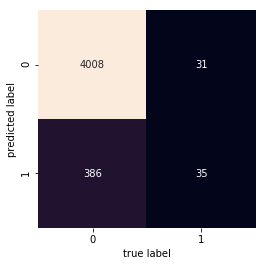

In [0]:
# Gradient Boosting tree 

tree_gb = ensembleClassifier(nEstimators = 40, resampling=DownSampling, rs_factor = 40,threshold =0.65)
tree_gb.fit(X = X_train, y = y_train)
score = tree_gb.score(X_test, y_test)
score

Accuracy:  0.8338565022421525
Classification report: 
p               precision    recall  f1-score   support

           0       0.99      0.84      0.91      4394
           1       0.05      0.59      0.10        66

   micro avg       0.83      0.83      0.83      4460
   macro avg       0.52      0.71      0.50      4460
weighted avg       0.98      0.83      0.90      4460



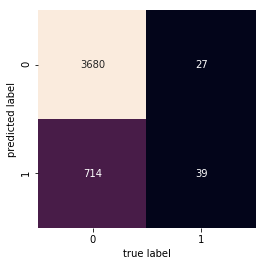

In [0]:
# Gradient Boosting tree without symptoms
tree_gb_nos = ensembleClassifier(nEstimators = 40, resampling=DownSampling, rs_factor = 40,threshold =0.5)
tree_gb_nos.fit(X = X_nos_train, y = y_nos_train)
score = tree_gb_nos.score(X_nos_test, y_nos_test)
score

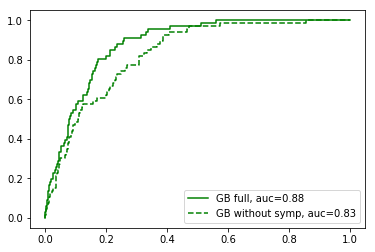

In [0]:
#AUC for gb
y_pred_proba = tree_gb.avg_yprob
y_nos_pred_proba = tree_gb_nos.avg_yprob
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
fpr_nos, tpr_nos, _ = metrics.roc_curve(y_test,  y_nos_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_nos = metrics.roc_auc_score(y_test, y_nos_pred_proba)
plt.plot(fpr,tpr,c='g',label="GB full, auc="+str(round(auc,3)))
plt.plot(fpr_nos,tpr_nos,c='g',linestyle='dashed',label="GB without symp, auc="+str(round(auc_nos,3)))
plt.legend(loc=4)

In [0]:
|